## Import required Libraries <br>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


## Loading dataset <br>

In [ ]:

df = pd.read_csv('Delhi_temp.csv')

# Clean column names
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()

# Check first few rows
print(df.head())


         time  temperature_2m_max  temperature_2m_min  sunshine_duration  \
0  2021-03-24                33.1                22.3           41320.10   
1  2021-03-25                33.1                21.9           41423.17   
2  2021-03-26                34.2                21.8           41525.67   
3  2021-03-27                36.0                23.4           41627.54   
4  2021-03-28                37.4                25.3           41728.68   

   rain_sum  precipitation_probability_max  wind_speed_10m_max  \
0       0.0                              0                22.3   
1       0.0                              0                18.8   
2       0.0                              0                17.2   
3       0.0                              0                10.2   
4       0.0                              0                 6.8   

   et0_fao_evapotranspiration  
0                        6.89  
1                        8.28  
2                        7.70  
3                 

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1192 entries, 0 to 1191
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   time                           1192 non-null   object 
 1   temperature_2m_max             1192 non-null   float64
 2   temperature_2m_min             1192 non-null   float64
 3   sunshine_duration              1192 non-null   float64
 4   rain_sum                       1192 non-null   float64
 5   precipitation_probability_max  1192 non-null   int64  
 6   wind_speed_10m_max             1192 non-null   float64
 7   et0_fao_evapotranspiration     1192 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 74.6+ KB
None


## Parse Dates and Create Time Features <br>

In [ ]:
df['time'] = pd.to_datetime(df['time'])
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day
df['weekday'] = df['time'].dt.weekday


## Feature Engineering
# Convert sunshine_duration from seconds to hours.<br>
# Create will_rain binary label from rain_sum.<br>

In [ ]:
# Convert sunshine duration to hours
df['sunshine_duration'] = df['sunshine_duration'] / 3600.0

# Target variable: 1 if it rained, 0 if not
df['will_rain'] = df['rain_sum'].apply(lambda x: 1 if x > 0 else 0)


## Prepare Features and Labels <br>

In [ ]:
# Features to use (drop time-related or leakage columns)
features = [
    'temperature_2m_max', 'temperature_2m_min', 'sunshine_duration',
    'precipitation_probability_max', 'wind_speed_10m_max',
    'et0_fao_evapotranspiration', 'month', 'day', 'weekday'
]

X = df[features]
y = df['will_rain']

## Train/Test and Scaling <br>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Train Random Forest Model <br>

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)


RandomForestClassifier(random_state=42)

## Evaluate Model <br>

In [ ]:
# Predict probabilities and classes
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]  # Probability of rain

# Evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.95       201
           1       0.88      0.58      0.70        38

    accuracy                           0.92       239
   macro avg       0.90      0.78      0.83       239
weighted avg       0.92      0.92      0.91       239

Confusion Matrix:
[[198   3]
 [ 16  22]]
ROC AUC Score: 0.9067818800733176


## Plot ROC Curve<br>

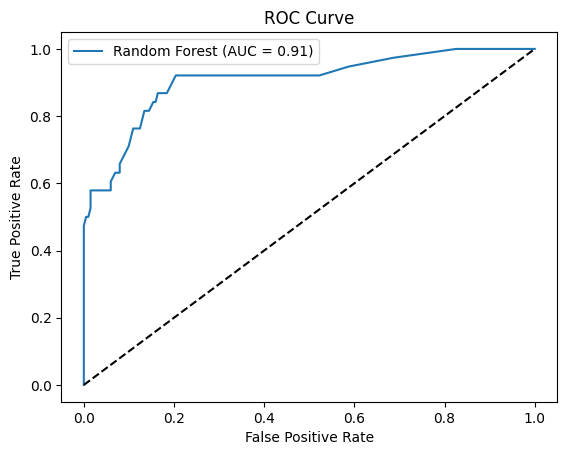

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label='Random Forest (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Predict Rain Probability for new Data<br>

In [ ]:
# Example new input
new_data = pd.DataFrame([{
    'temperature_2m_max': 36,
    'temperature_2m_min': 24,
    'sunshine_duration': 11.5,  # hours
    'precipitation_probability_max': 30,
    'wind_speed_10m_max': 20,
    'et0_fao_evapotranspiration': 7,
    'month': 5,
    'day': 2,
    'weekday': 4  # Friday
}])

# Scale new input and predict
new_scaled = scaler.transform(new_data)
rain_chance = model.predict_proba(new_scaled)[0][1] * 100
print(f"🌧️ Probability of Rain: {rain_chance:.2f}%")


🌧️ Probability of Rain: 9.00%


In [ ]:
import pickle
# Save the trained model using pickle
with open('rain_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model saved as 'rain_model.pkl'")

# Save the scaler using pickle
with open('rain_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Scaler saved as 'rain_scaler.pkl'")


Model saved as 'rain_model.pkl'
Scaler saved as 'rain_scaler.pkl'


In [ ]:
!pip install gradio
import gradio as gr
import pandas as pd
import pickle

# Load model and scaler
with open('rain_model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('rain_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Prediction function
def predict_rain(temp_max, temp_min, sunshine_hours, precip_prob, wind_speed, evap, month, day, weekday):
    input_df = pd.DataFrame([{
        'temperature_2m_max': temp_max,
        'temperature_2m_min': temp_min,
        'sunshine_duration': sunshine_hours,
        'precipitation_probability_max': precip_prob,
        'wind_speed_10m_max': wind_speed,
        'et0_fao_evapotranspiration': evap,
        'month': month,
        'day': day,
        'weekday': weekday
    }])

    scaled_input = scaler.transform(input_df)
    rain_chance = model.predict_proba(scaled_input)[0][1] * 100
    return f"🌧️ Rain Probability: {rain_chance:.2f}%"

# Create the UI with Dark Grey Theme
with gr.Blocks(theme=gr.themes.Base()) as demo:
    gr.HTML(
        """
        <div style="text-align: center; color: #F0F0F0; background-color: #333333; padding: 20px;">
            <h1 style="font-size: 36px; color: #FFFFFF; font-weight: bold;">🌦️ Rain Probability Predictor</h1>
            <p style="font-size: 18px; color: #D0D0D0;">Enter the weather parameters to predict the chance of rain.</p>
        </div>
        """
    )

    with gr.Row():
        with gr.Column():
            temp_max = gr.Slider(10, 50, value=30, label="🌡️ Max Temperature (°C)", elem_id="temp_max")
            temp_min = gr.Slider(0, 40, value=20, label="🌡️ Min Temperature (°C)", elem_id="temp_min")
            sunshine = gr.Slider(0, 15, value=10, step=0.1, label="☀️ Sunshine Duration (hrs)", elem_id="sunshine")
            precip = gr.Slider(0, 100, value=50, step=1, label="🌧️ Precipitation Probability (%)", elem_id="precip")

        with gr.Column():
            wind = gr.Slider(0, 50, value=15, step=0.1, label="💨 Wind Speed (km/h)", elem_id="wind")
            evap = gr.Slider(0, 15, value=5, step=0.1, label="💧 Evapotranspiration", elem_id="evap")
            month = gr.Slider(1, 12, value=5, step=1, label="📅 Month", elem_id="month")
            day = gr.Slider(1, 31, value=2, step=1, label="📅 Day", elem_id="day")
            weekday = gr.Dropdown(choices=[
                "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
            ], label="🗓️ Day of the Week", value="Friday", elem_id="weekday")

    # Convert weekday string to int before prediction
    def wrapped_prediction(*args):
        weekday_map = {
            "Monday": 0, "Tuesday": 1, "Wednesday": 2,
            "Thursday": 3, "Friday": 4, "Saturday": 5, "Sunday": 6
        }
        return predict_rain(*args[:-1], weekday_map[args[-1]])

    submit_btn = gr.Button("🔍 Predict Rain Chance", elem_id="submit_btn")
    output_text = gr.Textbox(label="Prediction Result", elem_id="output_text")

    submit_btn.click(fn=wrapped_prediction,
                     inputs=[temp_max, temp_min, sunshine, precip, wind, evap, month, day, weekday],
                     outputs=output_text)

# Launch the app
demo.launch(share=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.0 MB/s eta 0:00:00
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://186903046f98a99c54.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
